In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class EMNIST(Dataset):
    
    def __init__(self, csv_file):
        fashion_data = pd.read_csv(csv_file, header=None)
        numpy_arr = fashion_data.loc[:,:].to_numpy()
        self.length = numpy_arr.shape[0]
        self.y_data = torch.from_numpy(numpy_arr[:,0])
        self.x_data = torch.from_numpy(numpy_arr[:,1:]/255)

    def __getitem__(self,index):
        return self.y_data[index], self.x_data[index]

    def __len__(self):
        return self.length

def convert_to_one_hot(num, l):
    hot = np.zeros((1,l))
    hot[0,num] = 1.0
    return hot  

def accuracy(labels ,images, batch, forwardPass):
    
    '''
    For test images: labels = Ground truth values
                     images = Pass image to get final output  then compare
                     forwardPass = True
                     
    For train images: labels = Ground truth values
                      images = Pass Output LABEL of net to get (not image)
                      forwardPass = False
    '''
    if forwardPass:
        outputs = net(images.float().to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = np.array(predicted.cpu())
        
    else:
        _, predicted = torch.max(images, 1)
        predicted = np.array(predicted.cpu())
        
    ground_truth = np.array([labels[j] for j in range(batch)])
    correct_predictions = batch - np.count_nonzero(ground_truth - predicted )
    accuracy = correct_predictions*100/batch
    return accuracy

In [3]:
train_dataset = EMNIST('emnist-byclass-train.csv')
train_loader = DataLoader(dataset = train_dataset, batch_size = 2**16,shuffle=True)

batch_size_test_data = 1024
test_dataset = EMNIST('emnist-byclass-test.csv')
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size_test_data,shuffle=True)

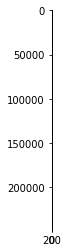

In [8]:
dataiter = iter(train_loader)
labels,images = dataiter.next()

images_grid = images.view(-1,1,28,28)
img_grid = torchvision.utils.make_grid(images_grid,nrow=8)
plt.imshow(img_grid[1,:,:], cmap='gray')

classes = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
           '0','1','2','3','4','5','6','7','8','9',
           'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'];

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 784)
        self.fc3 = nn.Linear(84, 62)
        self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
#         x = self.softmax(x)
        return x


net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
net

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
  (relu): ReLU()
)

In [11]:
#  tensorboard --logdir=runs

writer = SummaryWriter('runs/fashion_mnist_experiment_2')

test_dataiter = iter(test_loader)
test_labels ,test_images= test_dataiter.next() 

iterations = 200


for epoch in range(iterations+1):
    running_loss = 0.0
    for i,data in enumerate(train_loader):

        train_labels, train_images = data
        outputs, inputs = Variable(train_labels).to(device), Variable(train_images).to(device)
#         one_hots = torch.Tensor([convert_to_one_hot(int(i),10) for i in outputs]).view(1,-1)
        
        y_pred = net.forward(inputs.float().to(device))

        loss = criterion(y_pred, outputs.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        test_accuracy = accuracy(test_labels,test_images, batch_size_test_data-1, forwardPass = True)
        train_accuracy = accuracy(train_labels,y_pred, len(train_dataset)-1, forwardPass = False)
        
    if epoch % 2 == 0:
        print('epochs: {}, loss: {:.5f}, train_accuracy: {:.5f}, test_accuracy: {:.5f}'
              .format(epoch, running_loss,test_accuracy,train_accuracy))
        writer.add_scalar('training loss',running_loss, epoch)
        
    if epoch % 100 == 0:
        PATH = './saved_model.pth'
        torch.save(net.state_dict(), PATH)
        print("Model Saved! at epoch no.: {}".format(epoch))

writer.close()

ValueError: operands could not be broadcast together with shapes (1023,) (1024,) 

In [ ]:
def predictions(PATH, images, validation_size, device):
    net = Net().to(device)
    net.load_state_dict(torch.load(PATH))
    outputs = net(images.float().to(device))
    _, predicted = torch.max(outputs, 1)
    predicted = [classes[predicted[j]] for j in range(validation_size)]
    print('Predicted: ', ' '.join('%5s' % prediction for prediction in predicted))
    
    
validation_size = 8
model_PATH = 'saved_model.pth'

validation_dataset = FashionDataset('emnist-byclass-test.csv')
validation_loader = DataLoader(dataset = validation_dataset, batch_size = validation_size,shuffle=True)
dataiter = iter(validation_loader)
labels ,images= dataiter.next()

images_grid = images.view(-1,1,28,28)
img_grid = torchvision.utils.make_grid(images_grid,nrow=8)
plt.imshow(img_grid[1,:,:], cmap='gray')
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

predictions(model_PATH, images, validation_size, device) 